## Timeline Figure

In [1]:
from Bio import Entrez
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def search(query):
    Entrez.email = 'dan.lurie@berkeley.edu'
    handle = Entrez.esearch(db='pubmed', 
                            sort='date', 
                            retmax='100000',
                            retmode='xml', 
                            term=query)
    results = Entrez.read(handle)
    return results

In [3]:
def fetch_details(id_list):
    ids = ','.join(id_list)
    Entrez.email = 'dan.lurie@berkeley.edu'
    handle = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=ids)
    results = Entrez.read(handle)
    return results

### Pull all fMRI TVC papers

In [4]:
tvc_all = search('("dynamic connectivity"[TIAB] OR \
             "dynamic functional connectivity"[TIAB] OR \
             "dynamic FC"[TIAB] OR \
             "connectivity dynamics"[TIAB] OR \
             "FC dynamics"[TIAB] OR \
             "functional network dynamics"[TIAB] OR \
             "FC network dynamics"[TIAB] OR \
             "functional brain network dynamics"[TIAB] OR \
             "time-varying connectivity"[TIAB] OR \
             "time-varying functional connectivity"[TIAB] OR \
             "time-varying FC"[TIAB] OR \
             "time varying connectivity"[TIAB] OR \
             "time varying functional connectivity"[TIAB] OR \
             "time varying FC"[TIAB] OR \
             "time resolved connectivity"[TIAB] OR \
             "time resolved functional connectivity"[TIAB] OR \
             "time resolved FC"[TIAB] OR \
             "time-resolved connectivity"[TIAB] OR \
             "time-resolved functional connectivity"[TIAB] OR \
             "time-resolved FC"[TIAB] OR \
             "dynamic functional network connectivity"[TIAB]) AND \
             ("functional magnetic resonance imaging"[TIAB] OR "functional MRI"[TIAB] OR "fmri"[TIAB])')

In [5]:
tvc_all_papers = fetch_details(tvc_all['IdList'])

Pull article title and publication year for each article.

In [6]:
paper_records_tvc_all = []
for record in tvc_all_papers['PubmedArticle']:
    paper_records_tvc_all.append((record['MedlineCitation']['Article'].get('ArticleTitle', "?"), record['PubmedData']['History'][2].get('Year', "?")))

In [7]:
tvc_all_papers_df = pd.DataFrame.from_records(paper_records_tvc_all, columns=['Title', 'Year'])

Check for duplicate papers.

In [8]:
tvc_all_papers_df[tvc_all_papers_df.duplicated(subset='Title', keep=False)]

,Title,Year
155,Abnormal dynamic functional connectivity of am...,2018
178,Abnormal dynamic functional connectivity of am...,2018


Drop duplicate papers.

In [9]:
tvc_all_papers_df = tvc_all_papers_df.drop_duplicates(subset='Title')

Double-check that our pre-print isn't included in this list.

In [10]:
tvc_all_papers_df[tvc_all_papers_df['Title'].str.contains("nature")].values

array([['EEG Signatures of Dynamic Functional Network Connectivity States.',
        '2017']], dtype=object)

### Pull only resting fMRI TVC papers

In [11]:
tvc_rest = search('("dynamic connectivity"[TIAB] OR \
             "dynamic functional connectivity"[TIAB] OR \
             "dynamic FC"[TIAB] OR \
             "connectivity dynamics"[TIAB] OR \
             "FC dynamics"[TIAB] OR \
             "functional network dynamics"[TIAB] OR \
             "FC network dynamics"[TIAB] OR \
             "functional brain network dynamics"[TIAB] OR \
             "time-varying connectivity"[TIAB] OR \
             "time-varying functional connectivity"[TIAB] OR \
             "time-varying FC"[TIAB] OR \
             "time varying connectivity"[TIAB] OR \
             "time varying functional connectivity"[TIAB] OR \
             "time varying FC"[TIAB] OR \
             "time resolved connectivity"[TIAB] OR \
             "time resolved functional connectivity"[TIAB] OR \
             "time resolved FC"[TIAB] OR \
             "time-resolved connectivity"[TIAB] OR \
             "time-resolved functional connectivity"[TIAB] OR \
             "time-resolved FC"[TIAB] OR \
             "dynamic functional network connectivity"[TIAB]) AND \
             ("functional magnetic resonance imaging"[TIAB] OR "functional MRI"[TIAB] OR "fmri"[TIAB]) AND \
             ("rest"[TIAB] OR "resting"[TIAB] OR "resting-state"[TIAB] OR "intrinsic"[TIAB])')

In [12]:
tvc_rest_papers = fetch_details(tvc_rest['IdList'])

Pull article title and publication year for each article.

In [13]:
paper_records_tvc_rest = []
for record in tvc_rest_papers['PubmedArticle']:
    paper_records_tvc_rest.append((record['MedlineCitation']['Article'].get('ArticleTitle', "?"), record['PubmedData']['History'][2].get('Year', "?")))

In [14]:
tvc_rest_papers_df = pd.DataFrame.from_records(paper_records_tvc_rest, columns=['Title', 'Year'])

Check for duplicate papers.

In [15]:
tvc_rest_papers_df[tvc_rest_papers_df.duplicated(subset='Title', keep=False)]

,Title,Year
128,Abnormal dynamic functional connectivity of am...,2018
146,Abnormal dynamic functional connectivity of am...,2018


Drop duplicate papers.

In [16]:
tvc_rest_papers_df = tvc_rest_papers_df.drop_duplicates(subset='Title')

Double-check that our pre-print isn't included in this list.

Get counts for publications by year.

In [17]:
all_counts = tvc_all_papers_df.Year.value_counts().copy()
rest_counts = tvc_rest_papers_df.Year.value_counts().copy()

In [18]:
all_counts = all_counts.sort_index()
rest_counts = rest_counts.sort_index()

In [19]:
# Drop papers prior to 2010 and before 2019
all_counts = all_counts[3:-2]
rest_counts = rest_counts[0:-2] # rest_counts only starts at 2011,

In [20]:
# Add a zero value for 2010 to rest_counts so that it is the same length as all_counts
rest_counts = pd.Series([0], index=['2010']).append(rest_counts)

In [21]:
all_counts

2010      2
2011      3
2012      5
2013      9
2014     24
2015     34
2016     54
2017     99
2018    105
Name: Year, dtype: int64

In [22]:
rest_counts

2010     0
2011     2
2012     2
2013     7
2014    17
2015    24
2016    38
2017    77
2018    82
dtype: int64

Normalize yearly counts by the total number of articles published each year (manually taken from PubMed)

In [23]:
year_totals = np.array([942591, 1022236, 1088609, 1148796, 1204287, 1256569, 1282581, 1296941, 1335180])

In [24]:
all_counts_norm = all_counts/year_totals
rest_counts_norm = rest_counts/year_totals

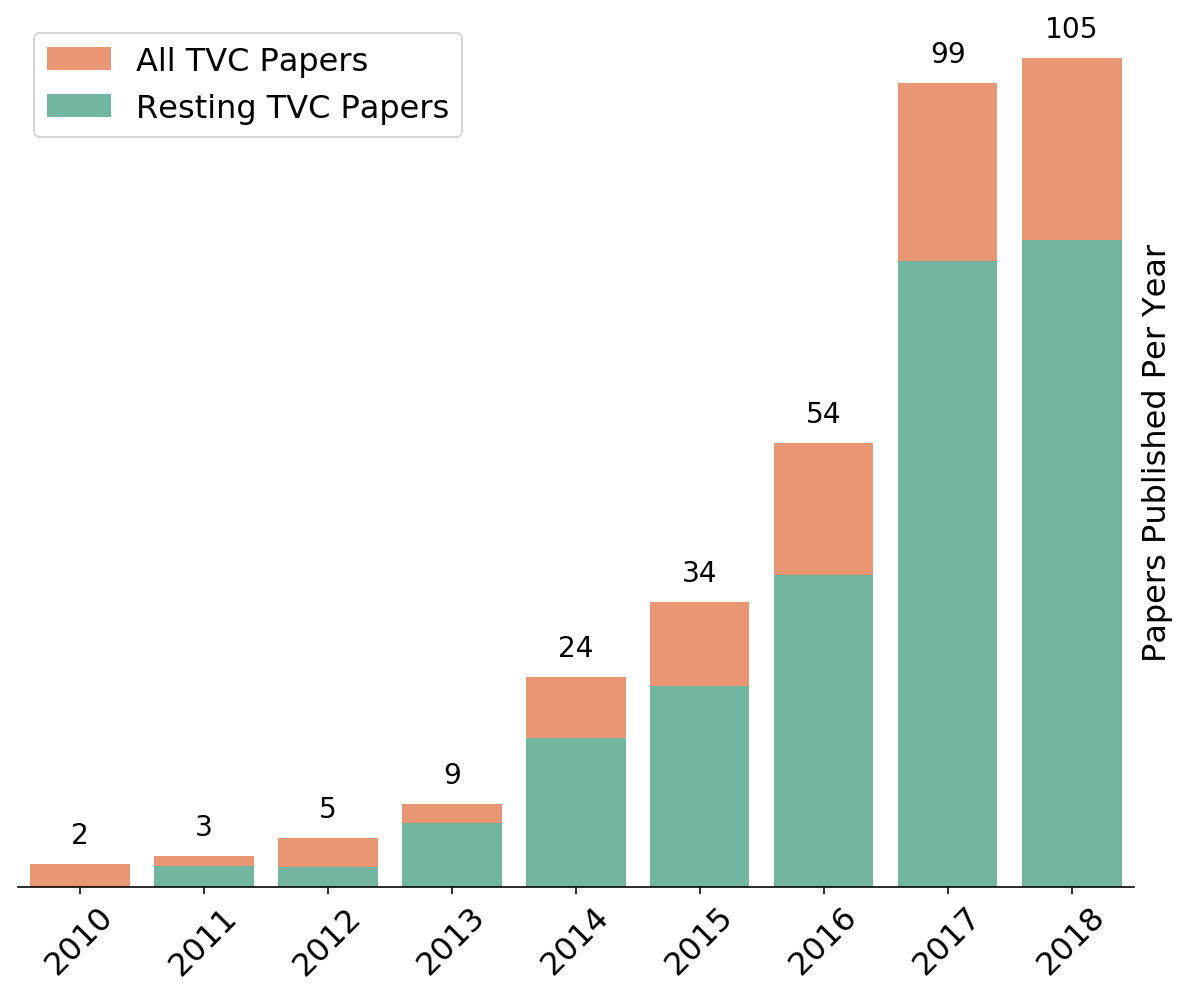

In [25]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(all_counts.index, all_counts_norm, color="#fc8d62", label="All TVC Papers")
sns.barplot(rest_counts.index, rest_counts_norm, color="#66c2a5", label='Resting TVC Papers')

for i in range(len(all_counts.index)):
    ax.text(x = i , y = all_counts_norm[i]+0.000002, s = all_counts[i], horizontalalignment='center', fontdict={'size':'14'})
    
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(left=False, labelleft=False, labelsize=16)
plt.xticks(rotation=45)
plt.ylabel('Papers Published Per Year', size=16)
ax.yaxis.set_label_position("right")
plt.legend(prop={'size': 16})
fig.savefig('../figs/timeline.eps', dpi=300)